# User Behavior

Describe user behavior using:
1. Product funnel. Comparison with benchmarks.
2. User retention. Define _critical event_ and _product usage interval_.
3. User active hours.
4. Most profitable categories of goods.
5. "People buy together" - find goods, that can be recommended to user.

In [1]:
%load_ext sql
%config SqlMagic.autopandas = True

# connect to local DuckDB database
%sql duckdb://:@/ecommerce_store.duckdb

## Funnel

In [38]:
%%sql df_funnel <<
select count(case when is_view = 1 then user_id end)     as user_viewed_cnt,
       count(case when is_cart = 1 then user_id end)     as user_carted_cnt,
       count(case when is_purchase = 1 then user_id end) as user_purchased_cnt
from user_stage_stat

*  duckdb://:***@/ecommerce_store.duckdb
Done.


In [39]:
df_funnel = df_funnel.rename(columns={'user_viewed_cnt': 'Item view',
                                      'user_carted_cnt': 'Cart',
                                      'user_purchased_cnt': 'Purchase'})

In [40]:
from plotly import graph_objects as go


def plot_funnel(df_funnel):
    user_counts = df_funnel.values.ravel()
    stages = df_funnel.columns
    fig = go.Figure(go.Funnel(
        y = stages,
        x = user_counts,
        textposition = "inside",
        textinfo = "value+percent initial"))
    return fig

plot_funnel(df_funnel)

### _Analysis_

To be able to analyse the Product Funnel, we need to estimate the _number of visitors_. Having this information, we would be able to compare ours metrics to the industry benchmarks.

#### Estimation of the _# of visitors_.



We will use the following formula:

$$
\text{Total \# of visitors} = \frac{\text{\# of visitors with view}}{1 - \text{Bounce Rate}}
$$

This works correctly under the assumptions:
1. The visitor could either bounce or view some item, exclusively. That is, visitor with no item view = bounced visitor.
2. Bounce Rate is equal to $35\%$. 
    According to the SimilarWeb, this is the benchmark for the Bounce Rate in eCommerce industry ([link](https://www.similarweb.com/blog/ecommerce/retail-insights/ecommerce-benchmarks-metrics/)). 

In [30]:
n_visitors_not_bounced = 3696114
bounce_rate_benchmark = .35
n_visitors_total = int(n_visitors_not_bounced/(1 - bounce_rate_benchmark))

print('Total # of visitors: ', n_visitors_total)

Total # of visitors:  5686329


Let's complete the Product Funnel with this information:

In [41]:
df_funnel.insert(loc=0, column='Visit', value=[n_visitors_total])
plot_funnel(df_funnel)

#### Is the Conversion Rate good?

Our conversion rate (from visit to purchase) is $7.8\%$, which is almost identical to the industry benchmark $7.7%$ ( according to the [SimilarWeb](https://www.similarweb.com/blog/ecommerce/retail-insights/ecommerce-benchmarks-metrics/)).

Conclusion: **🟢 The Conversion Rate is at the average level across industry.**



## User Retention

In order to define the appropriate retention metrics, we need to understand:
1. Critical event 
2. Product usage interval.


#### Define Critical Event
According to the [Amplitude](https://amplitude.com/mastering-retention/critical-event-product-usage-interval):
> A _critical event_ is an action that users take within your product
> that aligns closely with your core value proposition.

The only valuable event for the business in our case is **purchase**. Though we could also work with retetion in visit, for example, to analyse the stickiness of our product.

#### Define Product Usage Interval

Let's analyse the retention in visit to get insights, how frequently the product is used.

For the simplicity, we will concider only on cohort (from the 1 Nov 2019).


In [75]:
%%sql df_view_retention <<

select cohort_date,
       period_num,
       user_viewed_cnt,
       user_viewed_cnt::numeric / cohort_total_user_viewed_cnt as user_viewed_percent
from user_retention
where cohort_date in ('2019-11-01'::date, '2019-11-05'::date);

*  duckdb://:***@/ecommerce_store.duckdb
Done.


In [83]:
import plotly.express as px

fig = px.line(df_view_retention,
              x="period_num", y="user_viewed_cnt",
              title=f'Retention in view',
              color='cohort_date',
              markers=True)
fig.update_traces(textposition="bottom right")

fig.update_layout(
    xaxis=dict(
        title='# of Days since first view',
        linecolor='black',
        ticks='outside',
        tickfont=dict(
            family='Verdana',
            size=14,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        title='# of Viewers',
        showticklabels=True,
        tickfont=dict(
            family='Verdana',
            size=14,
            color='rgb(82, 82, 82)',
        ),
    ),
    autosize=True,
    margin=dict(
        autoexpand=False,
        l=100,
        r=200,
        t=50,
    ),
    showlegend=True,
    plot_bgcolor='whitesmoke'
)

fig.show()

We see that:

- There is an activity splash on 15th day. However, that's only because 15th November is a special day. We shouldn't take it into account when analyzing retention curve.
- The retention curve is pretty smooth, withoug any pits or retention splashed (except for 15th November, but that's not relevant).

Conclusion: **1 month is the best choice of product usage interval**. 


In [3]:
%%sql
create temp table cohort
as 
select user_id,
    min(event_time::date) as cohort_date
from user_event
group by user_id
having min(event_time::date) = '2019-11-01'::date


*  duckdb://:***@/ecommerce_store.duckdb
Done.


,Count
0,223107


In [5]:
%%sql


with a as (
    select
        cohort_date,
        count(distinct user_event.user_id)                           as cohort_user_cnt,
        count(distinct case when event_time::date - cohort_date = 1 
                            then user_event.user_id
                       end)                                          as user_returned_1_day_cnt,
        count(distinct case 
                            when event_time::date - cohort_date between 1 and 30 
                            then user_event.user_id
                       end)                                          as user_returned_30_days_cnt
    from user_event
        join cohort
        using (user_id)
    group by cohort_date
)
select cohort_date,
       round(100 * user_returned_1_day_cnt::numeric / cohort_user_cnt, 0)::text || '%' as "Retention in view (on 1st day)",
       round(100 * user_returned_30_days_cnt::numeric / cohort_user_cnt, 0)::text || '%' as "Retention in view (during 30 days)"
from a

*  duckdb://:***@/ecommerce_store.duckdb
Done.


,cohort_date,Retention in view (on 1st day),Retention in view (during 30 days)
0,2019-11-01,19.0%,73.0%


This confirms my observation, that user's usage interval is no shorter than 1 month. 

We can see that Retention to View on the next day is `19%`, which is not bad, but during 30 days much more users return - approximately `73%`.

We should track Monthly Retention.

Recommendation:

1. _Use mailings to manually return users during their first month_. The pattern shows, that most users are willing to return, and this can be exploited.
    - Time of the mailing can be chosen based on user activity data. Generally, it's better to send emails right before the most active period in day.

#### Retention Metric

Based on the choice of the critical event (purchase) and product usage interval (1 month), the main Retention metric is the **_Retention in purchase during first 30 days_**

In [7]:
%%sql

with a as (
    select
        cohort_date,
        count(distinct user_event.user_id)                           as cohort_user_cnt,
        count(distinct case when event_time::date - cohort_date = 1 
                            then user_event.user_id
                       end)                                          as user_returned_1_day_cnt,
        count(distinct case 
                            when event_time::date - cohort_date between 1 and 30 
                            then user_event.user_id
                       end)                                          as user_returned_30_days_cnt
    from user_event
        join cohort
        using (user_id)
    where event_type = 'purchase'
    group by cohort_date
)
select cohort_date,
       round(100 * user_returned_30_days_cnt::numeric / cohort_user_cnt, 0)::text || '%' as "Retention in Purchase (during 30 days)"
from a

*  duckdb://:***@/ecommerce_store.duckdb
Done.


,cohort_date,Retention in Purchase (during 30 days)
0,2019-11-01,82.0%


Conclusion:
- Customers, who already have made the purchase, have a very good habit for the recurring purchases. 

## User most active hours

In [10]:
%%sql df_hours_activity <<

select date_part('hour', event_time) as hour,
       count(*) as views_cnt
from user_event
where event_type = 'view'
group by date_part('hour', event_time)
order by hour

*  duckdb://:***@/ecommerce_store.duckdb
Done.


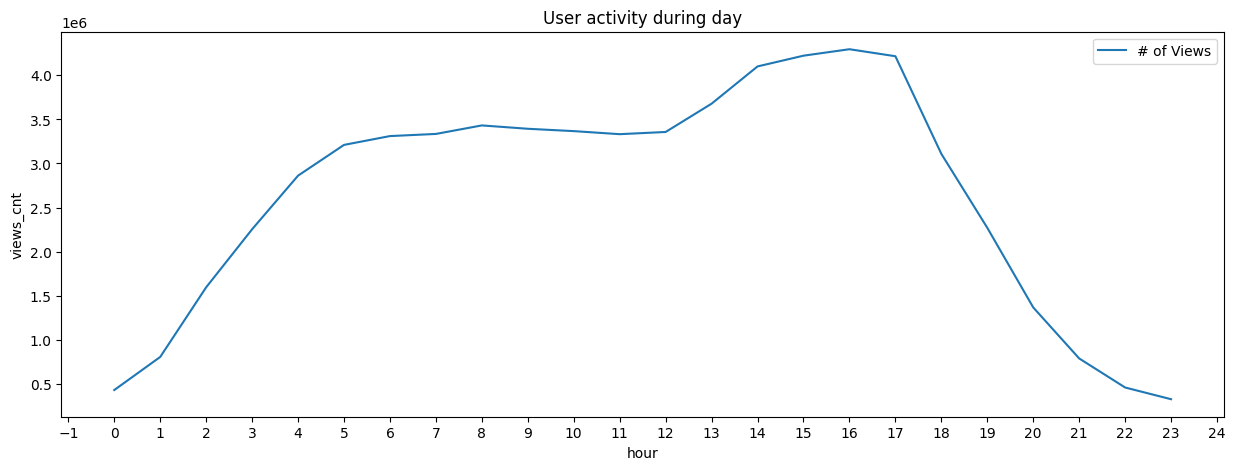

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

sns.lineplot(df_hours_activity, x='hour', y='views_cnt', label='# of Views')
import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
plt.gca().xaxis.set_major_locator(loc)
plt.title('User activity during day');

Recommendation:
- The best time for the mailing, or some other actions towards users, is `1PM` - at this moment starts the most active period for the users.

## The most successful goods


In [9]:
%%sql df_category_stat <<

select category_code,
       count(case when event_type = 'view' then 1 end)              as item_viewed_cnt,
       count(case when event_type = 'purchase' then 1 end)          as item_purchased_cnt,
       sum(case when event_type = 'purchase' then price else 0 end) as revenue
from user_event
group by category_code

*  duckdb://:***@/ecommerce_store.duckdb
Done.


In [4]:
df_category_stat.sort_values('revenue', ascending=False).head(10).style.format({'revenue': '${:.0f}'}).bar(subset=['revenue'])

,category_code,item_viewed_cnt,item_purchased_cnt,revenue
1,electronics.smartphone,14830550,382150,$177694981
3,undefined,20824435,234217,$29880313
2,electronics.video.tv,2070916,30274,$12457151
7,computers.notebook,2102264,18425,$10676228
5,electronics.clocks,1994363,23228,$6550398
16,appliances.kitchen.washer,1313463,19772,$5801906
18,electronics.audio.headphone,1644500,40832,$5669456
11,appliances.kitchen.refrigerators,1359836,13042,$4722657
0,appliances.environment.vacuum,1444815,18193,$2762312
17,computers.desktop,673875,3781,$1556638


Clearly, Smartphones generate the most of the revenue.

In [10]:
df_category_stat['parent_category'] = df_category_stat['category_code'].apply(lambda s: s.split('.')[0])
df_category_stat = df_category_stat.groupby('parent_category')[['item_viewed_cnt', 'item_purchased_cnt', 'revenue']].sum().sort_values('revenue', ascending=False)
df_category_stat['conversion_to_purchase'] = df_category_stat['item_purchased_cnt'] / df_category_stat['item_viewed_cnt']


In [11]:

df_category_stat.style.format({'conversion_to_purchase': '{:,.2%}'}).background_gradient(subset=['conversion_to_purchase'])

,item_viewed_cnt,item_purchased_cnt,revenue,conversion_to_purchase
parent_category,,,,
electronics,21985298,493129,205120584.330014,2.24%
undefined,20824435,234217,29880312.850001,1.12%
appliances,8031877,99026,18640501.670000,1.23%
computers,4028232,34469,13992129.200000,0.86%
furniture,2058239,11542,2543251.020000,0.56%
auto,1163016,10719,1375004.820000,0.92%
apparel,2942622,14215,1181025.120000,0.48%
construction,1047037,8699,1080390.700000,0.83%
kids,765732,6166,723763.260000,0.81%


_Conversion to Purchase_ tells us, how user is willing to buy the item. In other words, hot easy it's to sell this item to them.

The business may want to develop sections with goods, that have high conversion to purchase, such as `electronics`, `appliances`, `auto`, `computers`. Unfortunately, categories `medicine` and `stationery` are very small, and there is not much potential for busines.

Taking into account special interest to the Electronics category, especially in smartphones, we can consider increasing prices there.


#### "People buy together"

In [35]:
%%sql df_buy_together <<

with a as (
    select user_id,
           count(*)                                           as purchase_cnt,
           string_agg(split_part(category_code, '.', 1), ', ') as purchase_categories
    from user_event
    where event_type = 'purchase'
    group by user_id
)
select purchase_categories
from a
where purchase_cnt >= 2;

*  duckdb://:***@/ecommerce_store.duckdb
Done.


In [ ]:
import collections

import numpy as np
import pandas as pd
from tqdm import tqdm

user_purchase_categories = [s.split(', ') for s in df_buy_together['purchase_categories'].values]

categories = df_category_stat.reset_index()['parent_category'].unique()
df_cat_frequency = pd.DataFrame(data=np.zeros(shape=(len(categories), len(categories))), columns=categories, index=categories)

for user_cat_lst in tqdm(user_purchase_categories):
    purchase_dict = dict(collections.Counter(user_cat_lst))
    for cat in purchase_dict.keys():
        df_cat_frequency.loc[cat, cat] += purchase_dict[cat] - 1
        for other_cat in purchase_dict.keys():
            if cat != other_cat:
                df_cat_frequency.loc[other_cat, cat] += purchase_dict[other_cat]


for cat in categories:
    df_cat_frequency[cat] = df_cat_frequency[cat] / df_cat_frequency[cat].sum()
    df_cat_frequency.loc[cat, cat] = 0

In [66]:

print('Explanation: \n\teach column represents a category of purchased goods.')
print('\tIt contains information about what other categories were purchased by the same users.')
df_cat_frequency.style.format('{:,.0%}').background_gradient()

Explanation: 
	each column represents a category of purchased goods.
	It contains information about what other categories were purchased by the same users.


,electronics,undefined,appliances,computers,furniture,auto,apparel,construction,kids,sport,accessories,medicine,country_yard,stationery
electronics,0%,40%,38%,46%,28%,40%,39%,30%,34%,40%,30%,36%,23%,10%
undefined,17%,0%,24%,17%,32%,30%,29%,32%,31%,30%,32%,33%,37%,29%
appliances,7%,10%,0%,7%,13%,6%,7%,14%,10%,7%,7%,13%,10%,8%
computers,3%,3%,3%,0%,3%,2%,2%,3%,2%,3%,11%,2%,6%,9%
furniture,1%,2%,2%,1%,0%,1%,2%,2%,4%,3%,1%,1%,2%,1%
auto,1%,1%,1%,1%,1%,0%,1%,2%,1%,1%,1%,1%,5%,1%
apparel,1%,2%,2%,1%,3%,1%,0%,1%,3%,2%,6%,3%,1%,6%
construction,1%,1%,1%,1%,1%,1%,1%,0%,1%,1%,1%,1%,7%,2%
kids,0%,1%,1%,0%,2%,0%,1%,1%,0%,1%,1%,1%,0%,1%
sport,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,1%,1%,0%


We can see, that everyone wants `electronics`, `appliances` and also `undefined` category is popular. That's no surprise, let's exclude these categories to catch some unusual connections:

In [65]:
(
df_cat_frequency
.loc[~df_cat_frequency.index.get_level_values(0).isin(['electronics', 'undefined', 'appliances']), :]
.style
.format('{:,.0%}')
.background_gradient()
)

,electronics,undefined,appliances,computers,furniture,auto,apparel,construction,kids,sport,accessories,medicine,country_yard,stationery
computers,3%,3%,3%,0%,3%,2%,2%,3%,2%,3%,11%,2%,6%,9%
furniture,1%,2%,2%,1%,0%,1%,2%,2%,4%,3%,1%,1%,2%,1%
auto,1%,1%,1%,1%,1%,0%,1%,2%,1%,1%,1%,1%,5%,1%
apparel,1%,2%,2%,1%,3%,1%,0%,1%,3%,2%,6%,3%,1%,6%
construction,1%,1%,1%,1%,1%,1%,1%,0%,1%,1%,1%,1%,7%,2%
kids,0%,1%,1%,0%,2%,0%,1%,1%,0%,1%,1%,1%,0%,1%
sport,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,1%,1%,0%
accessories,0%,0%,0%,1%,0%,0%,1%,0%,0%,0%,0%,0%,0%,0%
medicine,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
country_yard,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%


Based on the information about:
- We can sell `electronics` and `appliances` to every user, regardless of their primary interests.
- You can sell `furniture` for the users, who are interested in `kids` category. If the person has a kid, they also have a household, that require furniture.
- `accessories` can be offered for the `computer` and `apparel` users.
- `country_yard` can be offered for the users, who are interested in `computers`, `auto`, `construction`.
- `stationery` can be offered for the users, who are interested in `computers`, `apparel`.